In [1]:
import jupyter
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import scipy
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import math
from classes.data import Data


In [2]:
def load_data(file):
    data = []
    with open(file) as f:
        for line in f:
            data.append(line.strip("\n").split(","))
    return data

def decision_tree(data, classLabel):
    arbre = tree.DecisionTreeClassifier()
    return arbre.fit(data, classLabel)




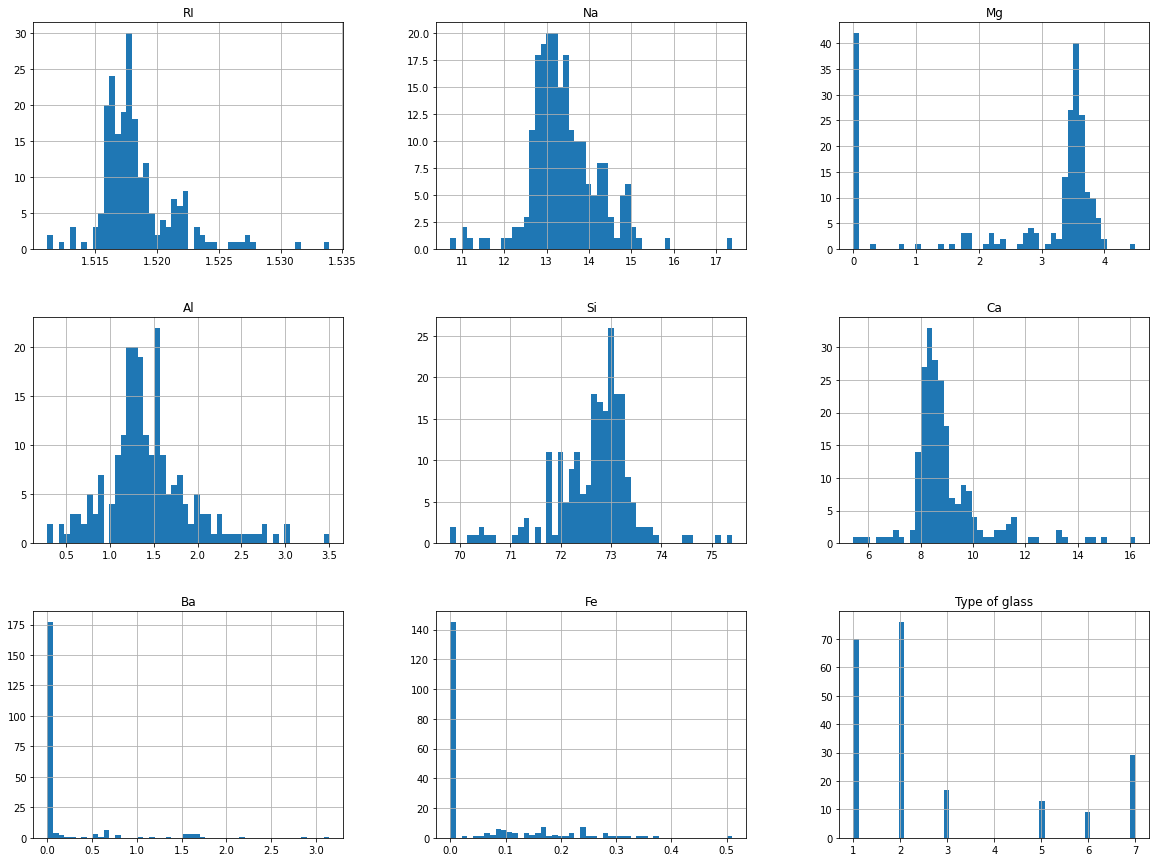

In [3]:


data = Data(load_data("glass.data"))
data.removeColumn("K")
data.data_frame.hist(bins=50, figsize=(20, 15))
plt.show()




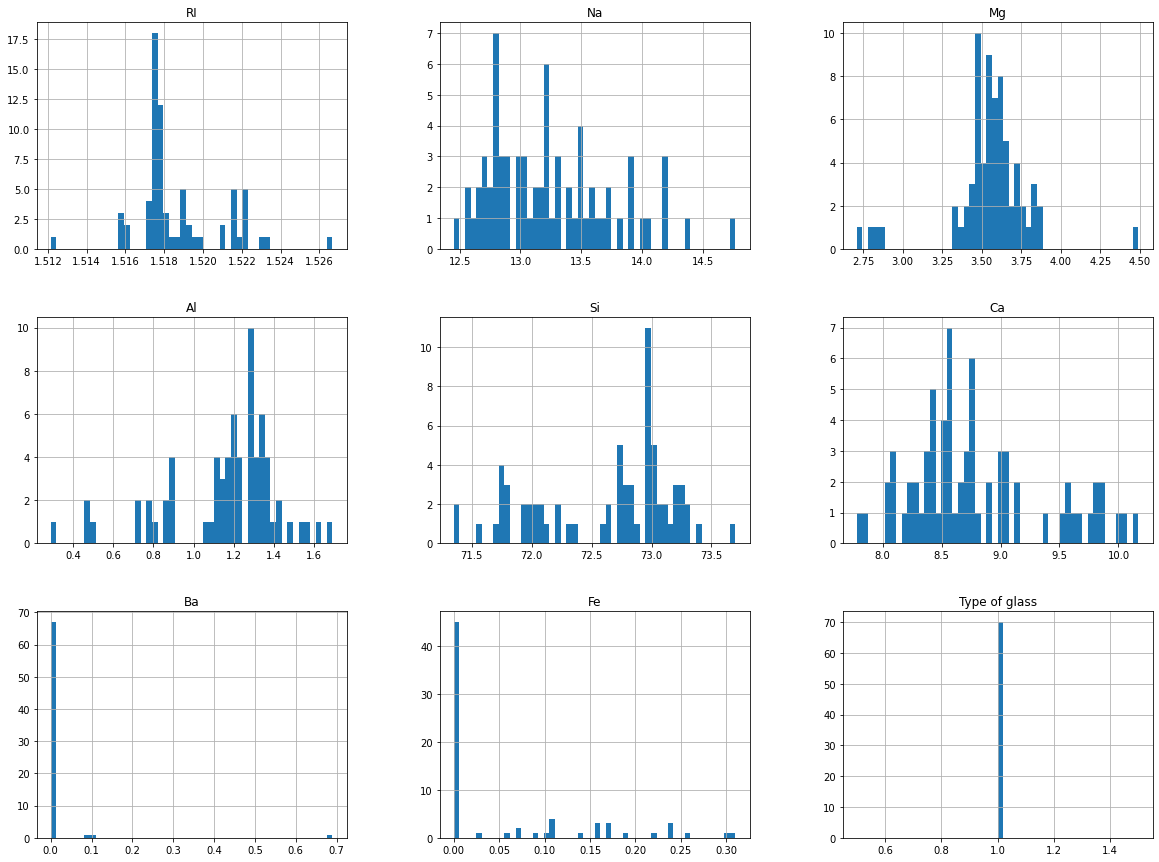

In [4]:
data.getClassData(1).hist(bins=50, figsize=(20, 15))
plt.show()

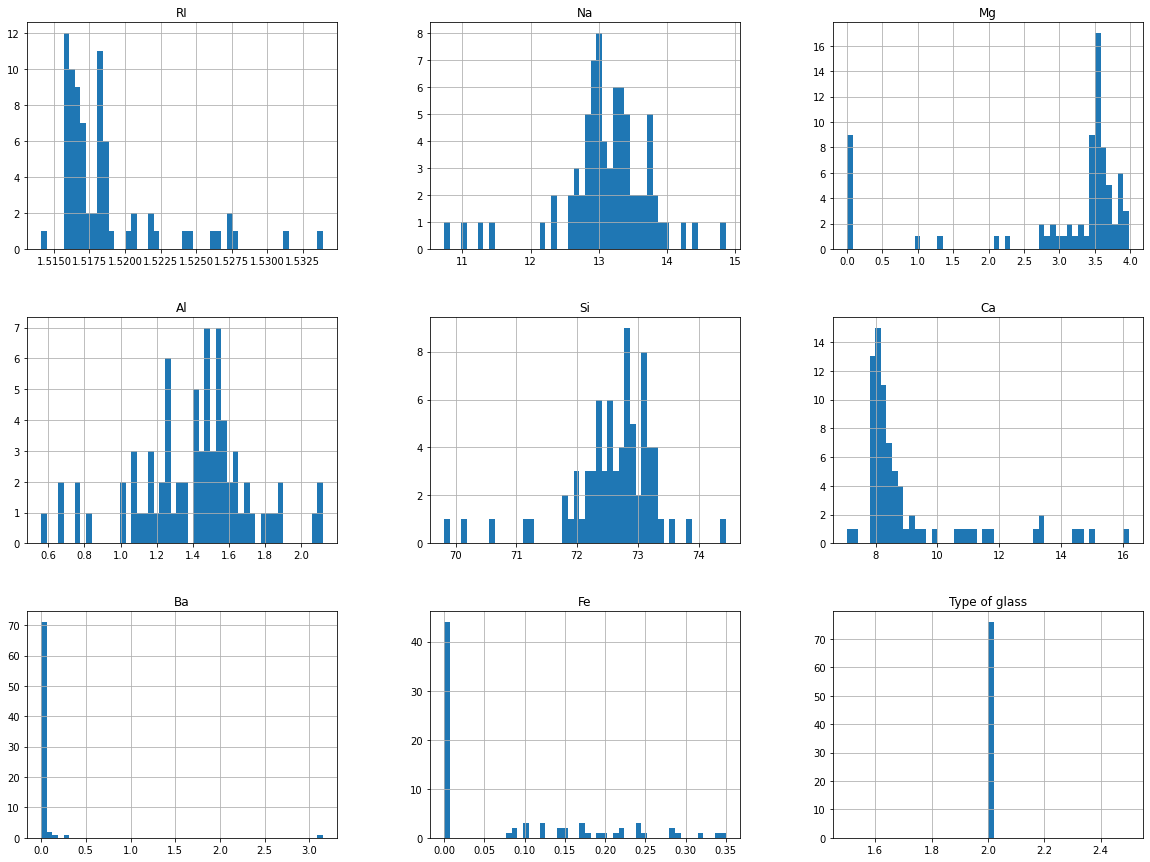

In [5]:
data.getClassData(2).hist(bins=50, figsize=(20, 15))
plt.show()

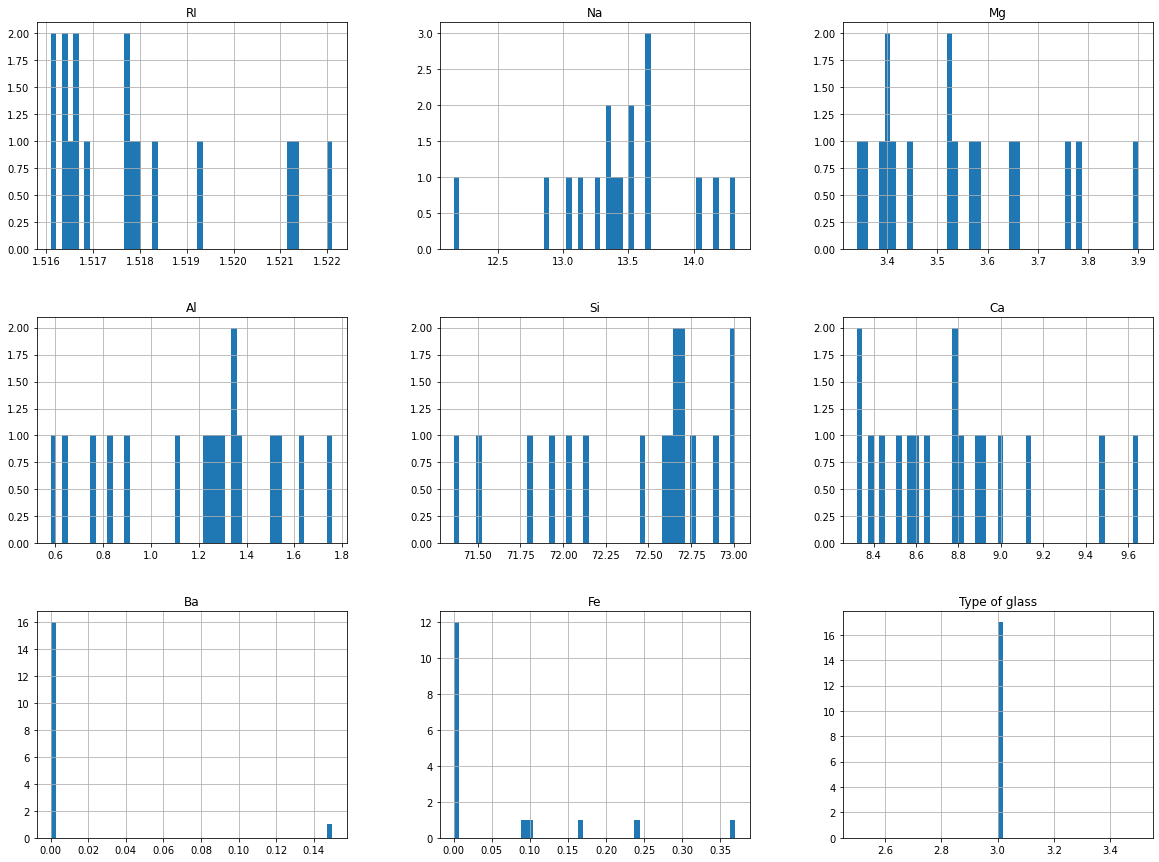

In [6]:
data.getClassData(3).hist(bins=50, figsize=(20, 15))
plt.show()

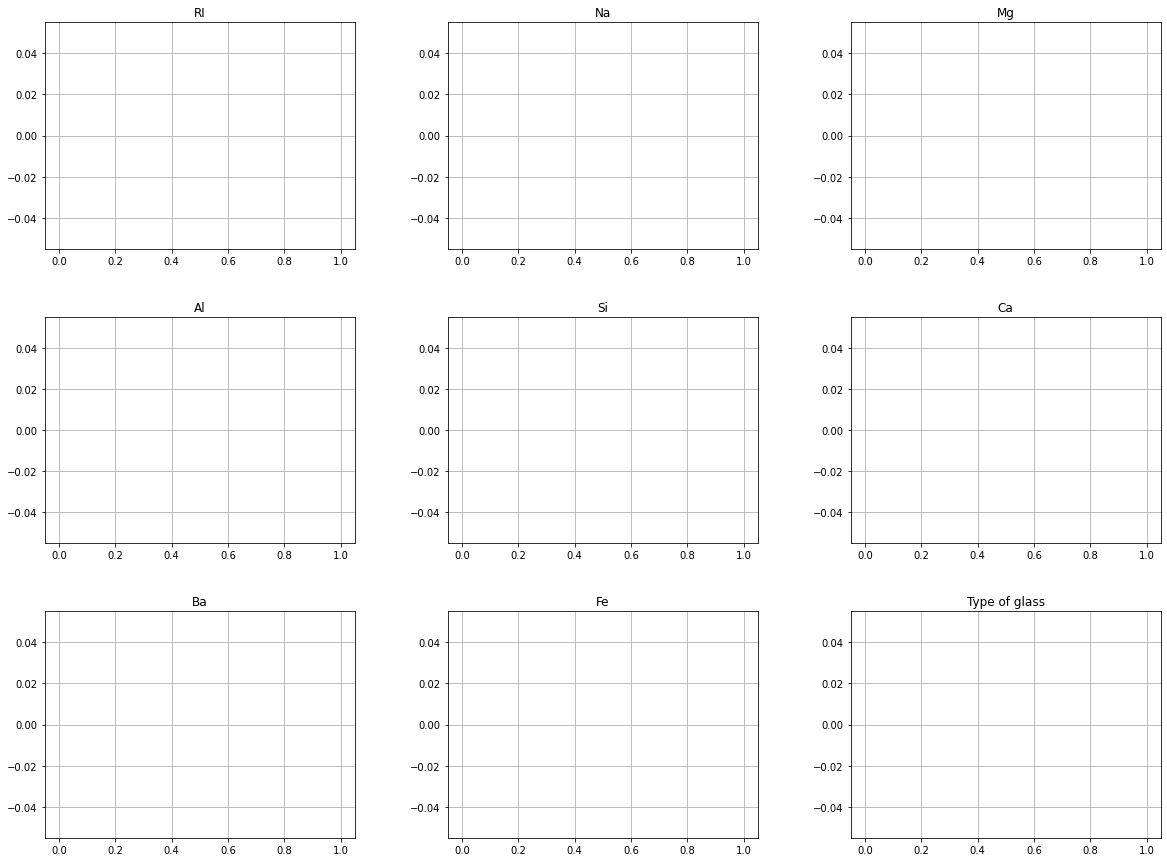

In [7]:
data.getClassData(4).hist(bins=50, figsize=(20, 15))
plt.show()

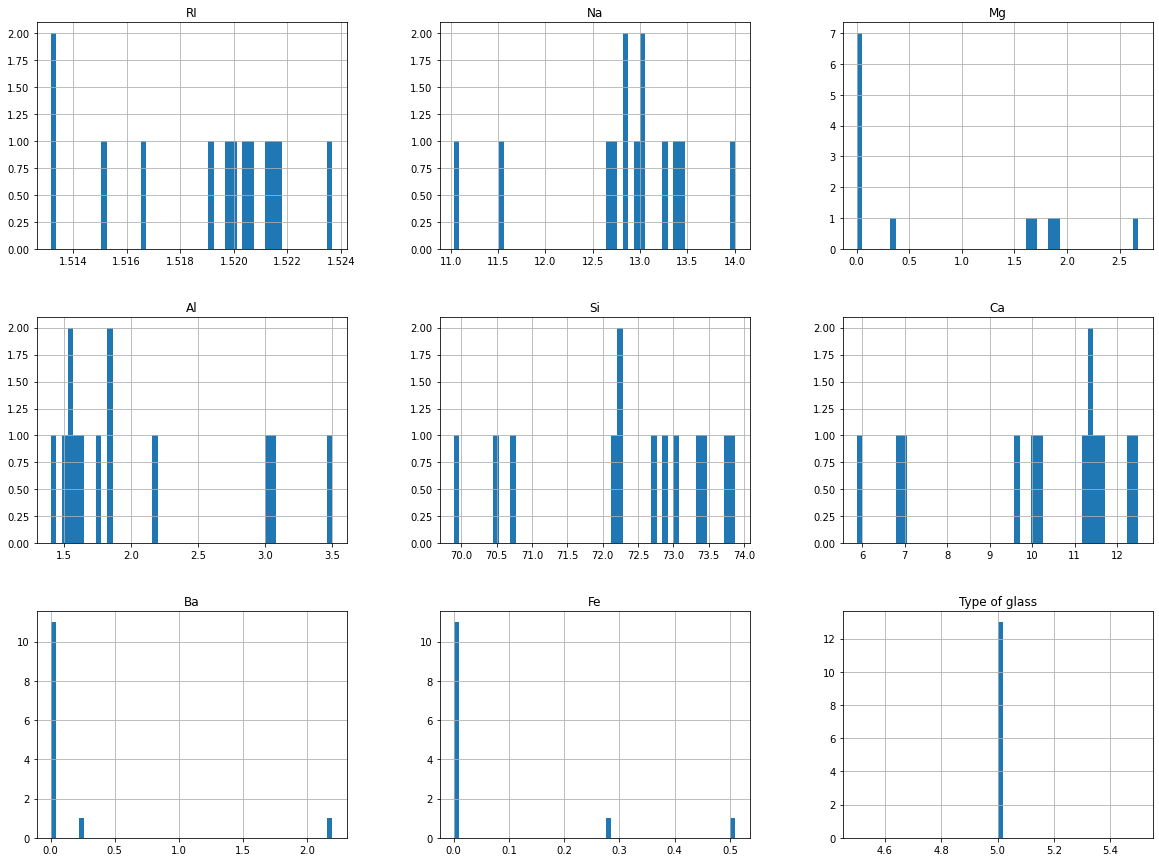

In [8]:
data.getClassData(5).hist(bins=50, figsize=(20, 15))
plt.show()

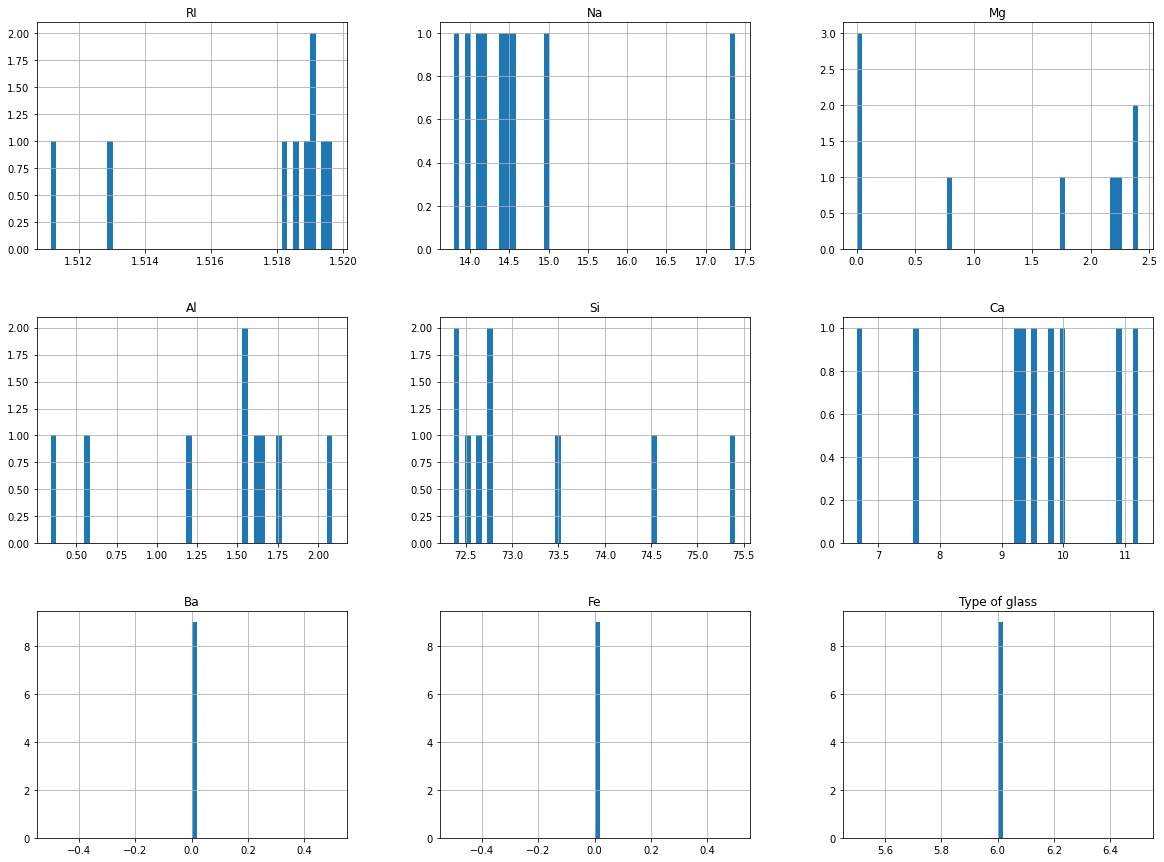

In [9]:
data.getClassData(6).hist(bins=50, figsize=(20, 15))
plt.show()

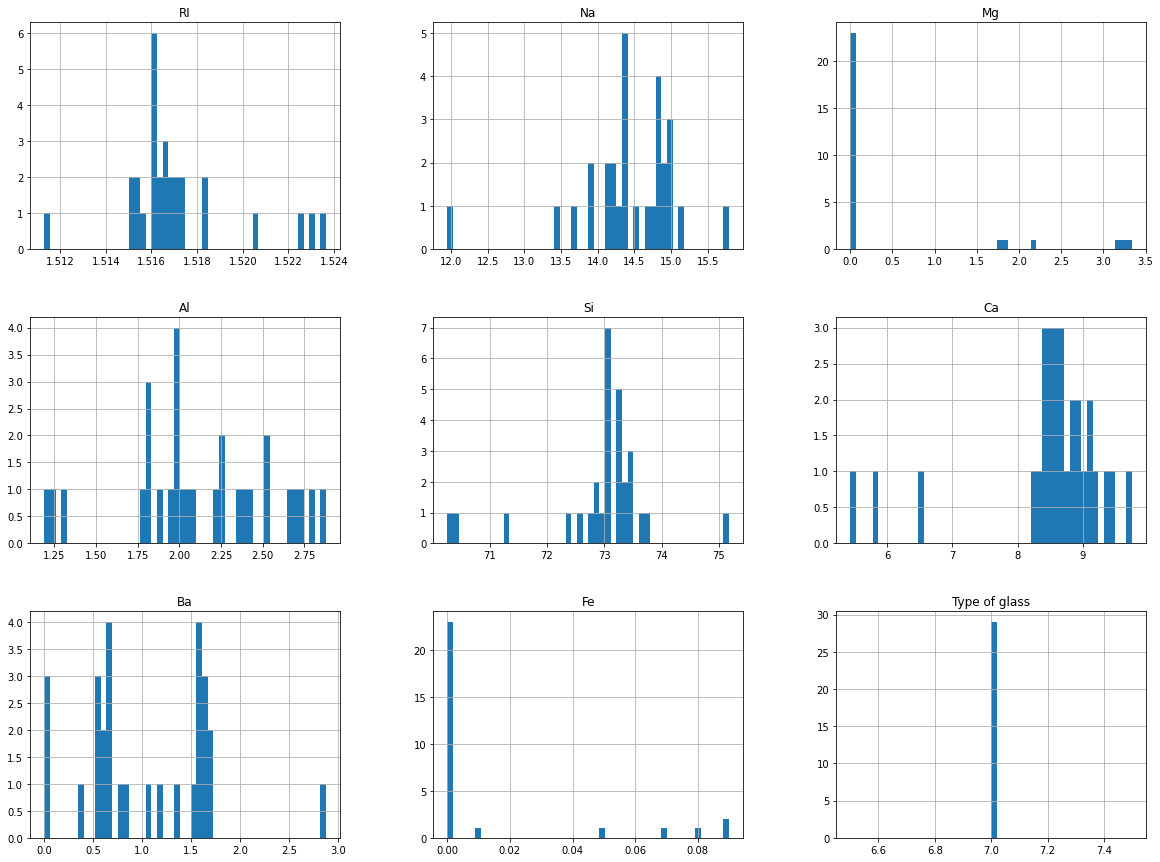

In [10]:
data.getClassData(7).hist(bins=50, figsize=(20, 15))
plt.show()

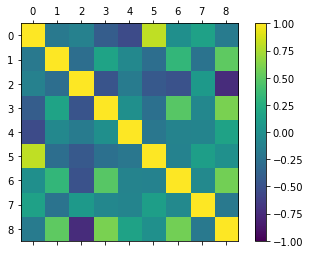

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.data_frame.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

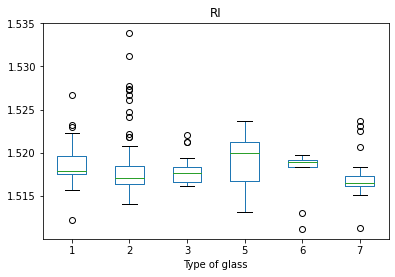

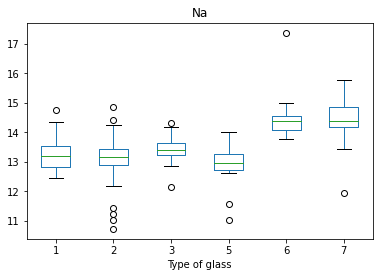

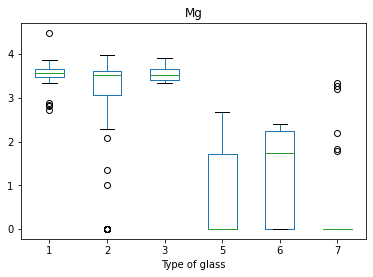

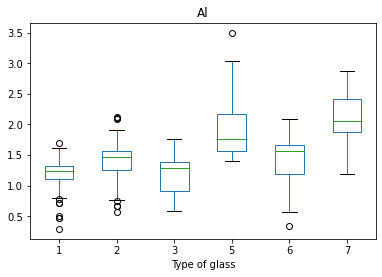

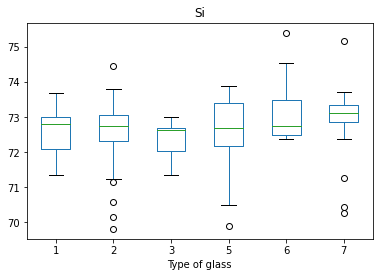

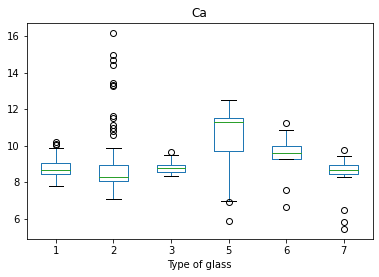

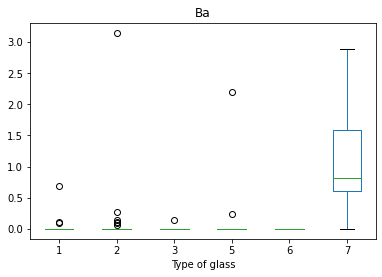

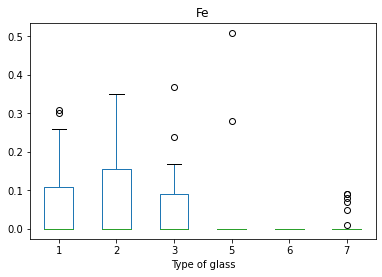

In [12]:
for column in data.data_frame.columns:
    if column == "Type of glass":
        continue
    data.data_frame.boxplot(column=column, by="Type of glass", grid=False)
    plt.suptitle('')
    plt.show()
    del(column)

In [13]:


train_features, test_features, train_label, test_label= data.splitNormalizedData(0.2)
arbre = decision_tree(train_features, train_label)
prediction = arbre.predict(test_features)
conf_mx = confusion_matrix(test_label, prediction)
conf_mx



array([[9, 0, 0, 0, 0, 2],
       [4, 9, 1, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 8]], dtype=int64)

In [14]:

gnb = GaussianNB()
baye_pred = gnb.fit(train_features, train_label).predict(test_features)
print("Number of mislabeled points out of a total %d points : %d" % ((test_features.shape[0]), (test_label != baye_pred).sum()))

Number of mislabeled points out of a total 43 points : 29


In [15]:

neigh = KNeighborsClassifier(n_neighbors = round(math.sqrt(train_features.shape[0])/7))
neigh.fit(train_features, train_label)
knn_pred = neigh.predict(test_features)

print("Number of mislabeled points out of a total %d points : %d" % ((test_features.shape[0]), (test_label != knn_pred).sum()))


Number of mislabeled points out of a total 43 points : 14
9      1
197    7
66     1
191    7
117    2
111    2
15     1
86     2
75     2
144    2
182    6
170    5
141    2
73     2
178    6
167    5
190    7
18     1
45     1
184    6
98     2
209    7
211    7
195    7
148    3
104    2
30     1
25     1
175    5
16     1
55     1
138    2
158    3
93     2
69     1
203    7
171    5
152    3
97     2
84     2
101    2
200    7
60     1
Name: Type of glass, dtype: int64
[1 7 1 7 2 2 1 2 2 1 5 2 1 1 6 5 6 1 1 6 2 7 7 7 1 1 1 1 2 1 2 2 2 2 1 7 5
 1 2 2 1 7 2]
